# Cannabis Stocks and Media Hype

Cannabis stocks have for a few years now been hyped up as the new "tech stocks", promising to be to current investors what Apple and Microsoft were decades ago. With marijuana fully legalized in Canada, and fully legal status or reduced decriminalization in thirty-seven of the United States, many investors jumped onboard in 2018 when major cannabis companies, some believing in the product, others believing in the profit. 

As the demand for the stocks increased, certain stocks saw near-exponential growth, to the wonder and admiration of investors and analysts alike. But how much of that growth was a natural reflection on the product and how much was artificially inflated hype?


## Step 1: Source Stock Data from NASDAQ

Using open-source Python code, I scraped stock information from NASDAQ for Tilray, Inc. (TLRY), Canopy Growth Corp. (CGC), Aurora Cannabis (ACB), and Cronos Group (CRON), four of the most commonly discussed cannabis stocks. These were then stored in JSON files.

In [1]:
from lxml import html
import requests
from time import sleep
import json
import argparse
from random import randint

import pandas as pd

In [2]:
f = open('tlry-summary.json')
data = json.load(f)
print(type(data))
data

<class 'dict'>


{'company_name': '',
 'ticker': 'tlry',
 'url': 'http://www.nasdaq.com/symbol/tlry',
 'open price': None,
 'open_date': None,
 'close_price': None,
 'close_date': None,
 'key_stock_data': {}}

That's not very useful. Also, for our purposes, we need historical data, not just the data for the current day, which is what the webpage presents. Fortunately, NASDAQ provides historical data in a csv file.

In [3]:
tlry = pd.read_csv('TLRYHistoricalQuotes.csv')
tlry_asc = tlry.iloc[::-1] #Putting the dates in ascending order
tlry_asc.head()

,Date,Close/Last,Volume,Open,High,Low
346,07/19/2018,$22.39,11912880,$23.05,$24.00,$20.10
345,07/20/2018,$29.77,13947110,$24.25,$31.80,$23.50
344,07/23/2018,$29.45,9984060,$33.48,$34.10,$29.31
343,07/24/2018,$25.36,5494133,$28.80,$29.43,$25.25
342,07/25/2018,$26.49,3845034,$25.31,$27.15,$24.20


In [4]:
acb = pd.read_csv('ACBHistoricalQuotes.csv')
acb_asc = acb.iloc[::-1]
acb_asc.head()

,Date,Close/Last,Volume,Open,High,Low
1258,12/03/2014,$0.91,N/A,$0.91,$0.91,$0.91
1257,12/04/2014,$0.91,N/A,$0.91,$0.91,$0.91
1256,12/05/2014,$0.91,N/A,$0.91,$0.91,$0.91
1255,12/08/2014,$0.91,N/A,$0.91,$0.91,$0.91
1254,12/09/2014,$0.91,N/A,$0.91,$0.91,$0.91


In [5]:
cgc = pd.read_csv('CGCHistoricalQuotes.csv')
cgc_asc = cgc.iloc[::-1]
cgc_asc.head()

,Date,Close/Last,Volume,Open,High,Low
1057,09/22/2015,$1.38,5324,$1.36,$1.38,$1.36
1056,09/23/2015,$1.33,10500,$1.36,$1.36,$1.33
1055,09/24/2015,$1.30,3734,$1.34,$1.35,$1.29
1054,09/25/2015,$1.32,9354,$1.34,$1.34,$1.32
1053,09/28/2015,$1.23,5914,$1.30,$1.30,$1.22


In [6]:
cron = pd.read_csv('CRONHistoricalQuotes.csv')
cron_asc = cron.iloc[::-1]
cron_asc.head()

,Date,Close/Last,Volume,Open,High,Low
20,11/04/2019,$8.08,4312321,$8.20,$8.30,$8.08
19,11/05/2019,$8.23,3596968,$8.12,$8.43,$8.08
18,11/06/2019,$8.33,3645152,$8.31,$8.48,$8.17
17,11/07/2019,$7.93,6158625,$8.40,$8.52,$7.86
16,11/08/2019,$8.52,7920348,$7.95,$8.60,$7.86


From the previews of the dataframes, we can see that Aurora Cannabis (ACB) was the first to go public in December 2014, followed by Canopy Growth Corporation (CGC) in September 2015. Tilray, Inc. (TLRY) and Cronos Group (CRON) are relatively new, going public in July 2018 and November 2019, respectively.

## Step 2: Data Preprocessing/Cleaning

In [7]:
print(tlry_asc.isnull().sum())
print(acb_asc.isnull().sum())
print(cgc_asc.isnull().sum())
cron_asc.isnull().sum()

Date           0
 Close/Last    0
 Volume        0
 Open          0
 High          0
 Low           0
dtype: int64
Date           0
 Close/Last    0
 Volume        0
 Open          0
 High          0
 Low           0
dtype: int64
Date           0
 Close/Last    0
 Volume        0
 Open          0
 High          0
 Low           0
dtype: int64


Date           0
 Close/Last    0
 Volume        0
 Open          0
 High          0
 Low           0
dtype: int64

Luckily, we have no null values to fill in. Now, let's limit our dataframe to the values we'll be using in our time series analysis. 

In [8]:
print(list(tlry_asc.columns))
print(list(acb_asc.columns))
print(list(cgc_asc.columns))
list(cron_asc.columns)

['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low']
['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low']
['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low']


['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low']

As we can see, there is a space before the names of the columns. We need to remove this to facilitate the processing of our data.

In [9]:
tlry_asc.rename(columns={' Close/Last':'Close',
                        ' Volume': 'Volume',
                        ' Open': 'Open',
                        ' High': 'High',
                        ' Low': 'Low'},
                inplace=True)
list(tlry_asc.columns)

['Date', 'Close', 'Volume', 'Open', 'High', 'Low']

In [10]:
acb_asc.rename(columns={' Close/Last':'Close',
                        ' Volume': 'Volume',
                        ' Open': 'Open',
                        ' High': 'High',
                        ' Low': 'Low'},
                inplace=True)
list(acb_asc.columns)

['Date', 'Close', 'Volume', 'Open', 'High', 'Low']

In [11]:
cgc_asc.rename(columns={' Close/Last':'Close',
                        ' Volume': 'Volume',
                        ' Open': 'Open',
                        ' High': 'High',
                        ' Low': 'Low'},
                inplace=True)
list(cgc_asc.columns)

['Date', 'Close', 'Volume', 'Open', 'High', 'Low']

In [12]:
cron_asc.rename(columns={' Close/Last':'Close',
                        ' Volume': 'Volume',
                        ' Open': 'Open',
                        ' High': 'High',
                        ' Low': 'Low'},
                inplace=True)
list(cron_asc.columns)

['Date', 'Close', 'Volume', 'Open', 'High', 'Low']

In [13]:
tlry_ts = tlry_asc.drop(columns=['Volume'])
acb_ts = acb_asc.drop(columns=['Volume'])
cgc_ts = cgc_asc.drop(columns=['Volume'])
cron_ts = cron_asc.drop(columns=['Volume'])

## Step 3: Time Series Analysis

Before we begin to consider the media hype's effects on the stock prices, we need to test for seasonality.

In [14]:
def get_datetimes(df):
    return pd.to_datetime(df.Date)

In [15]:
tlry_ts['Date'] = get_datetimes(tlry_ts)

acb_ts['Date'] = get_datetimes(acb_ts)

cgc_ts['Date'] = get_datetimes(cgc_ts)

cron_ts['Date'] = get_datetimes(cron_ts)

In [42]:
tlry_ts = tlry_ts.set_index('Date', inplace=True)
acb_ts = acb_ts.set_index('Date', inplace = True)
cgc_ts = cgc_ts.set_index('Date', inplace = True)
cron_ts = cron_ts.set_index('Date', inplace=True)

In [17]:
tlry_ts.Open = tlry_ts.Open.str.strip('$')
tlry_ts.Close = tlry_ts.Close.str.strip('$')
tlry_ts.High = tlry_ts.High.str.strip('$')
tlry_ts.Low = tlry_ts.Low.str.strip('$')

acb_ts.Open = acb_ts.Open.str.strip('$')
acb_ts.Close = acb_ts.Close.str.strip('$')
acb_ts.High = acb_ts.High.str.strip('$')
acb_ts.Low = acb_ts.Low.str.strip('$')

cgc_ts.Open = cgc_ts.Open.str.strip('$')
cgc_ts.Close = cgc_ts.Close.str.strip('$')
cgc_ts.High = cgc_ts.High.str.strip('$')
cgc_ts.Low = cgc_ts.Low.str.strip('$')

cron_ts.Open = cron_ts.Open.str.strip('$')
cron_ts.Close = cron_ts.Close.str.strip('$')
cron_ts.High = cron_ts.High.str.strip('$')
cron_ts.Low = cron_ts.Low.str.strip('$')

In [18]:
tlry_ts.Open = pd.to_numeric(tlry_ts.Open)
tlry_ts.Close = pd.to_numeric(tlry_ts.Close)
tlry_ts.High = pd.to_numeric(tlry_ts.High)
tlry_ts.Low = pd.to_numeric(tlry_ts.Low)

acb_ts.Open = pd.to_numeric(acb_ts.Open)
acb_ts.Close = pd.to_numeric(acb_ts.Open)
acb_ts.High = pd.to_numeric(acb_ts.High)
acb_ts.Low = pd.to_numeric(acb_ts.Low)

cgc_ts.Open = pd.to_numeric(cgc_ts.Open)
cgc_ts.Close = pd.to_numeric(cgc_ts.Close)
cgc_ts.High = pd.to_numeric(cgc_ts.High)
cgc_ts.Low = pd.to_numeric(cgc_ts.Low)

cron_ts.Open = pd.to_numeric(cron_ts.Open)
cron_ts.Close = pd.to_numeric(cron_ts.Close)
cron_ts.High = pd.to_numeric(cron_ts.High)
cron_ts.Low = pd.to_numeric(cron_ts.Low)

In [21]:
tlry_open = tlry_ts.drop(columns=['Close'])
tlry_close = tlry_ts.drop(columns=['Open'])

acb_open = acb_ts.drop(columns=['Close'])
acb_close = acb_ts.drop(columns=['Open'])

cgc_open = cgc_ts.drop(columns=['Close'])
cgc_close = cgc_ts.drop(columns=['Open'])

cron_open = cron_ts.drop(columns=['Close'])
cron_close = cron_ts.drop(columns=['Open'])

TypeError: 'NoneType' object is not subscriptable

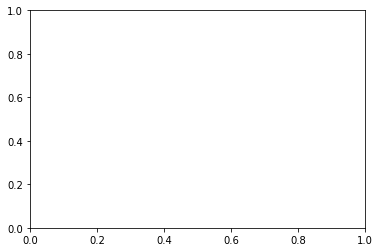

In [43]:
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from matplotlib.dates import date2num, DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
import numpy as np
from mpl_finance import candlestick2_ohlc
import datetime


fig, ax = plt.subplots()
ax.set_xlabel = tlry_ts['Date']
csticks = candlestick2_ohlc(ax, 
                            tlry_ts['Open'].values,
                            tlry_ts['Close'].values,
                            tlry_ts['High'].values,
                            tlry_ts['Low'].values,
                            width = 0.6,
                            colorup = 'r',
                            colordown = 'c')

plt.show()

TypeError: 'NoneType' object is not subscriptable

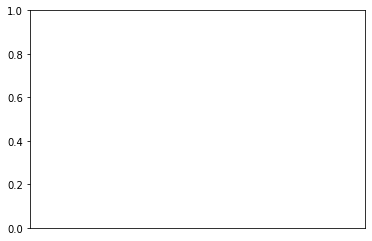

In [44]:
fig2, ax2 = plt.subplots()

mondays = WeekdayLocator(MONDAY)
alldays = DayLocator()          
weekFormatter = DateFormatter('%b %d')  
dayFormatter = DateFormatter('%d')

ax2.xaxis.set_major_locator(mondays)
ax2.xaxis.set_minor_locator(alldays)
ax2.xaxis.set_major_formatter(weekFormatter)
#ax2.xaxis.set_minor_formatter(dayFormatter)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)

csticks2 = candlestick2_ohlc(ax2, 
                             acb_ts['Open'].values,
                             acb_ts['Close'].values,
                             acb_ts['High'].values,
                             acb_ts['Low'].values,
                             width = 0.6,
                             colorup = 'g',
                             colordown = 'r')

ax2.xaxis_date()
ax2.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()